In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure
import pickle
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

import itertools

from tensorflow.keras.layers import Concatenate, Dense, Dropout
from tensorflow.keras.layers import Add, Activation, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Reshape, Dot
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model

from src.explore import explore_data, create_dis_rating, top_reviewers_plot, top_products_plot, sub_dataset
from src.cf_models import import_data, create_parameters_model, train_test, RecommenderNet
from src.get_data import get_data
from src.cross_val import cross_val_v1

pd.set_option('display.float_format', '{:.2f}'.format)

import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

# Movie Recommender Using Deep Neural Networks

## The project goal:

Building a high performance movies/TV recommender system to engage Amazon customers, so as to drive the movies/TV products sales. 


## Business Understanding

1. Entertainment products such as movies/TV market is increasing. A recommender system with high performance plays a key role to engage customers and to drive sales.
2. A recommender system is used to predict users' interests based on historical data, and recommend product items that are most likely interesting for users. 
3. Using Neural networks to build a recommendation system because deep neural networks can efficiently learn the underlying explanatory factors and useful representations, so as to produce high performance. 

## Data Understanding

1. Data used in this project are Amazon Movies/TV reviews from UCSD
2. The downloaded data are Json.gz files with 19 years data (8,765,568 reviews) 
3. The data used in this project is a subsample that only includes 2018 ratings/reviews, so as to reduce computational cost, and to better focus on the improve the model performance. 
4. In the meta datafile, there is a feature named"details" which is in html format and includes the links for that product. Used BeautifulSoup and Scraped webpage link.

## Process

1. Download the data
2. Extract the data from json.gz files, subsample the data, scrape the links, clean and preprocess the data for exploration and building the model.
3. Explore and visualize the dataset
4. Build the model
5. Corss Validation
6. Make Predicitons/Recommendations

## Step1: Download Data files

In [2]:
## use the following two lines of codes to download data files. The files will be saved as Movies_andTV_.json.gz and meta_Movies_and_TV.json.gz in the data folder. 
## I already downloaded and saved the data in the data folder, so I skip this step

# !wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_Movies_and_TV.json.gz
# !wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFiles/Movies_and_TV.json.gz

## Step2: Data Preparation for Exploration and Model Building

In [3]:
## after download the data, use get_data() from scr.get_data.py to get datafrom json.gz files, extract links from the 'details', clean the data and tramsform reviewerID and movieID into two different columns.
## data = get_data() will generate a cleaned dataset that will be used for exploration and model building. 
## Due to the data files are very large and takes long time to load, transform, and clean, I saved the output from get_data() to a csv file so that it is easy to run. 

## use the next line to get the data. warning: this step takes a long time because the json.gz files are very big, and extracting links takes long time as well. 

data = get_data() # I already got the data, so I skip this step 

# save the data to csv for future use
data.to_csv('../data/data_2018_mr.csv') ## I already saved the data, so I skip this one

In [2]:
# import the data from csv file saved from last step
data_2018 = pd.read_csv('../data/data_2018_mr.csv')

In [3]:
# take a look at the cleaned and preprocessed data
data_2018.head(3)

,Unnamed: 0,rating,reviewTime,reviewerID,movieID,style,reviewerName,reviewText,summary,unixReviewTime,...,main_cat,description,brand,price,links,reviewer_count,movie_count,average_rating,reviewer,movie
0,0,5.00,"04 8, 2018",A1CW3NLH9MBQRY,6303022901,{'Format:': ' DVD'},Sally Nunez,I really enjoyed this movie. Brings tears to m...,Five Stars,1523145600,...,Movies & TV,['Produced by Academy Award(R)-winning filmmak...,Tamlyn Tomita,$3.28,https://www.amazon.com/product-reviews/6303022...,3,21,4.86,3421,0
1,1,5.00,"04 2, 2018",A1WK0IRZ08NX9X,6303022901,{'Format:': ' DVD'},Ammie28,"If you have never seen this movie, you may jus...",Heart Touching...,1522627200,...,Movies & TV,['Produced by Academy Award(R)-winning filmmak...,Tamlyn Tomita,$3.28,https://www.amazon.com/product-reviews/6303022...,4,21,4.86,8655,0
2,2,5.00,"03 30, 2018",A2HGXJQCQTXE4E,6303022901,{'Format:': ' Blu-ray'},Pa nhia lee,awesome all time fave movie.,Five Stars,1522368000,...,Movies & TV,['Produced by Academy Award(R)-winning filmmak...,Tamlyn Tomita,$3.28,https://www.amazon.com/product-reviews/6303022...,4,21,4.86,14164,0


## Step3: Explore the data

In [4]:
# explore the dataset of 2018. The specific codes are in the src.explore.py file
explore_data()

Count of Reviewers: 35992
Count of Products: 20007

Ratings descriptive statistics: 
count   116700.00
mean         4.43
std          1.11
min          1.00
25%          4.00
50%          5.00
75%          5.00
max          5.00
Name: rating, dtype: float64

Reviewers by count descriptive statistics: 
count   35992.00
mean        3.24
std         3.44
min         1.00
25%         2.00
50%         2.00
75%         3.00
max        85.00
Name: rating, dtype: float64

Products by count descriptive statistics: 
count   20007.00
mean        5.83
std        15.32
min         1.00
25%         2.00
50%         2.00
75%         5.00
max       595.00
Name: rating, dtype: float64

Top reviwers by count of reviews: 
reviewerID
A471W6ANJU6W9     85
A3QXT4RO4RBPCL    83
A3EKNWZOV3EZXC    78
A2764UZVBFC61W    78
AJ2LH4FFW4QYX     71
AG8OC1AEP44WU     71
A1ADJ8AD91RE0J    70
AGB3M4QPM0MIU     67
A54ERXXP81MF      67
AUSLDE6RFBM2O     63
A292UXMLXC60UZ    63
A1UI1DY6CPWHY5    63
A3V0D97QKXDN5R    61
A3H

In [5]:
## get sub_dataset for visualization

data_2018, top_reviewers, top_products = sub_dataset()

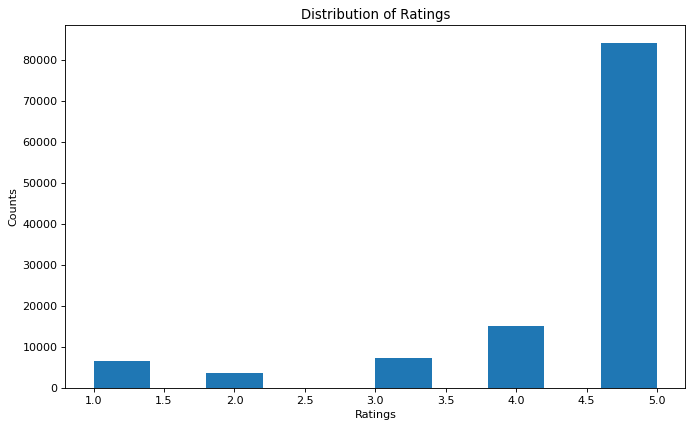

In [6]:
# visualize the distribution of ratings
rating_hist = create_dis_rating(data_2018)

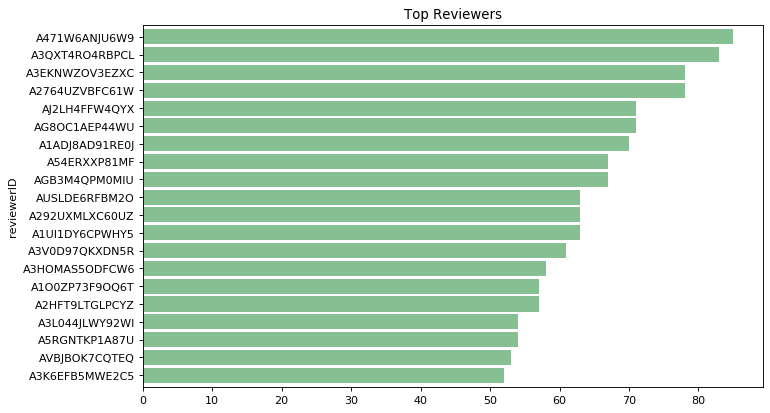

In [7]:
# visualize the top reviewers by count of ratings the reviewers gave
top_reviewers_plot(top_reviewers)

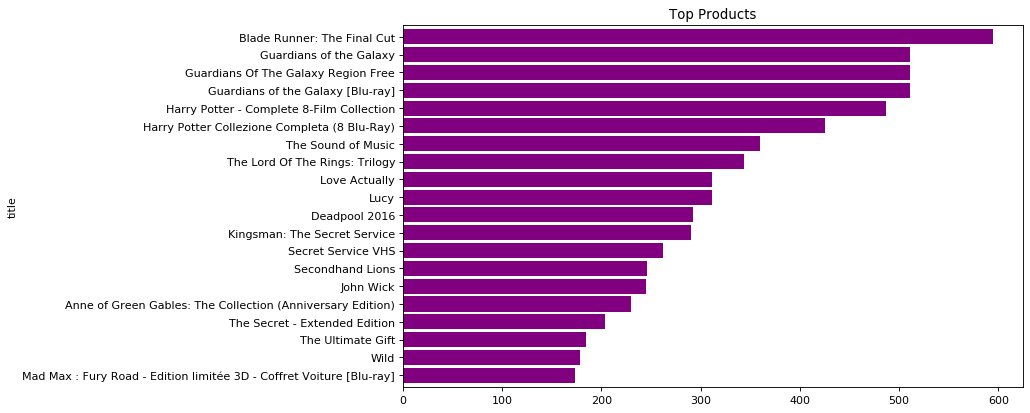

In [9]:
# visualize the top movies/TV by count of reviews for the products
top_products_plot(top_products)

## Findings:

1. Majority ratings are 5.
2. 50% reviewers only reviewed 1 movie.
3. 25% movies have only one review. 
4. Data is sparse. 

## Step4: Build the Deep Neural Networks Model

The cf_models.py file includes the base model and the final molde. The base model is a simple and basic model with only input and output layers. The final model added hidden layers and dropout to help prevent overfitting on the training dataset. The following model is the final model.

Loss function: Squared Mean Error

Metrics: Mean Absolute Error

In [10]:
# import cleaned data for model , it is the save data_2018_mr.csv
data_2018 = import_data()

In [11]:
# get parameters for the model
n_reviewers, n_movies, n_factors, min_rating, max_rating = create_parameters_model(data_2018)

In [5]:
# split train and test data for the model
X_train, X_test, X_train_array, X_test_array, y_train, y_test = train_test(data_2018)

In [6]:
# initialate the final model
model = RecommenderNet(n_reviewers, n_movies, n_factors, min_rating, max_rating)

In [7]:
# fit the data
history = model.fit(x=X_train_array, 
                    y=y_train, 
                    batch_size=64, 
                    epochs=5,
                    verbose=1, 
                    validation_data=(X_test_array, y_test))

Train on 93360 samples, validate on 23340 samples
Epoch 1/5


/Users/daihongchen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/daihongchen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


93360/93360 [==============================] - 29s 310us/sample - loss: 1.2747 - mae: 0.7780 - val_loss: 0.8710 - val_mae: 0.5021
Epoch 2/5
93360/93360 [==============================] - 27s 289us/sample - loss: 0.7034 - mae: 0.4500 - val_loss: 0.8013 - val_mae: 0.4580
Epoch 3/5
93360/93360 [==============================] - 27s 287us/sample - loss: 0.5478 - mae: 0.3690 - val_loss: 0.7736 - val_mae: 0.4444
Epoch 4/5
93360/93360 [==============================] - 27s 287us/sample - loss: 0.4710 - mae: 0.3250 - val_loss: 0.7839 - val_mae: 0.4403
Epoch 5/5
93360/93360 [==============================] - 27s 285us/sample - loss: 0.4368 - mae: 0.3043 - val_loss: 0.7858 - val_mae: 0.4322


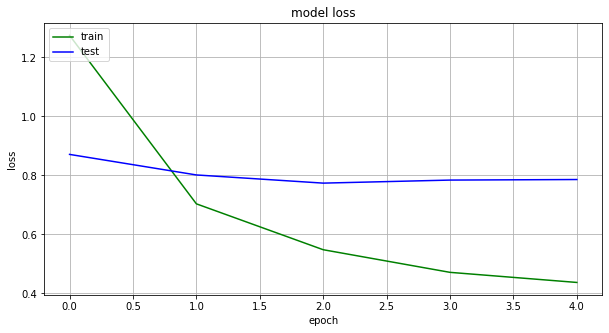

In [8]:
# visualize the final model loss
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(history.history['loss'] , 'g')
plt.plot(history.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

## Step5: Cross validation

In [13]:
cvscores, cvscore_mean, cvscore_std = cross_val_v1(X_train, y_train)

/Users/daihongchen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 74688 samples, validate on 18672 samples
Epoch 1/5
   32/74688 [..............................] - ETA: 11:21 - loss: 0.1892 - mae: 0.1751

/Users/daihongchen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


74688/74688 [==============================] - 44s 587us/sample - loss: 0.3979 - mae: 0.2882 - val_loss: 0.3012 - val_mae: 0.2180
Epoch 2/5
74688/74688 [==============================] - 43s 580us/sample - loss: 0.3988 - mae: 0.2888 - val_loss: 0.3858 - val_mae: 0.2677
Epoch 3/5
74688/74688 [==============================] - 46s 610us/sample - loss: 0.4055 - mae: 0.2932 - val_loss: 0.4904 - val_mae: 0.3177
Epoch 4/5
74688/74688 [==============================] - 45s 608us/sample - loss: 0.4021 - mae: 0.2911 - val_loss: 0.6424 - val_mae: 0.3727
Epoch 5/5
18672/18672 [==============================] - 2s 86us/sample - loss: 0.7363 - mae: 0.4074
mae 0.40737972
Train on 74688 samples, validate on 18672 samples
Epoch 1/5
74688/74688 [==============================] - 45s 600us/sample - loss: 0.5047 - mae: 0.3394 - val_loss: 0.3264 - val_mae: 0.2381
Epoch 2/5
74688/74688 [==============================] - 48s 642us/sample - loss: 0.4391 - mae: 0.3086 - val_loss: 0.4217 - val_mae: 0.2807
Epoc

In [17]:
# the cross validation scores for each split
cvscores

[0.40737972, 0.40187737, 0.384637, 0.3743945, 0.38229263]

In [18]:
# the average and the standard deviation of the cross validation scores
cvscore_mean, cvscore_std

(0.39011627, 0.012447937)

### Results

The Mean Absolute Error for the final model is 0.43, which indicates the model performns well.

## Step6: Make Predictions/Recommendations

In [9]:
# load the recommeder
from src.recommend_movies import recommender

In [10]:
rec = recommender(1000)

/Users/daihongchen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [11]:
rec

,movie,title,average_rating,category,description,price,links
19449,1162,Lean on Me,4.86,"['Movies & TV', 'Studio Specials', 'Warner Hom...",['Based on the true story of new jersey high s...,$15.00,https://www.amazon.com/product-reviews/6305133...
20855,2499,The Family Man,5.00,"['Movies & TV', 'Genre for Featured Categories...",NaN,$22.31,https://www.amazon.com/product-reviews/B000057...
34954,18583,Back to the Future 30th Anniversary Trilogy,4.59,"['Movies & TV', 'Boxed Sets', 'Comedy']",['Experience the future all over again with th...,$22.51,https://www.amazon.com/product-reviews/B011Q0F...
60138,4300,Evelyn,4.83,"['Movies & TV', 'Studio Specials', 'MGM Home E...","[""From the director of Driving Miss Daisy come...",$16.67,https://www.amazon.com/product-reviews/B00008D...
85188,15127,Futurama: The Complete Series,4.38,"['Movies & TV', 'Studio Specials', '20th Centu...",['As vast and hilarious as the universe itself...,$68.45,https://www.amazon.com/product-reviews/B00F77M...
